# Постановка задачи

В данном эксперименте сравниваются 3 алгоритмов для нахождения кратчайшего пути в графе:

1. Обычный алгоритм Дейкстры
2. Динамический вариант алгоритма Дейкстры
3. Алгоритм Беллмана-Форда

Сравнения будут производится в условиях динамического изменения графа, и целью эксперимента является нахождение ответа на вопрос, какой из трех предложенных алгоритмов позволяет получить наименьшее суммарное время на пересчет всех обновлений.

# Оборудование

Характеристики процессора, на котором производились замеры

In [42]:
! printf '\n========== CPU ==========\n'
! lscpu | grep -E 'Architecture|Model name|Thread\(s\)|Core\(s\)|MHz'


========== CPU ==========
Architecture:                    x86_64
Model name:                      Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz
Thread(s) per core:              2
Core(s) per socket:              2
CPU max MHz:                     3000.0000
CPU min MHz:                     500.0000


# Графы

Для сравнения будут использоваться графы, сгенерированные с помощью [NetworkX](https://networkx.org/documentation/stable/index.html). Было решено использовать графы 2 видов:

1. [Граф](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.les_miserables_graph.html#networkx.generators.social.les_miserables_graph) кооперации персонажей из Les Miserables (далее les_miserables)
2. [Граф](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.random_partition_graph.html#networkx.generators.community.random_partition_graph) random partition с различными параметрами (далее random_partition). Так как данный генератор позволяет создать граф любого размера, мы будем их далее различать по префиксу в названии. То есть, название графа random_partition_1000 трактуется как граф, созданный с помощью генератора random_partition, с количеством вершин 1000.

# Подготовка данных

Для начала подготовим графы нужного размера, а также наборы ребер, которые будут добавляться\удаляться

In [1]:
import random

import pandas as pandas
from networkx.generators import les_miserables_graph, random_partition_graph


def get_graphs():
    yield ["les_miserables", les_miserables_graph().to_directed()]
    yield ["random_partition_1000", random_partition_graph([200, 300, 500], 0.1, 0.01).to_directed()]
    yield ["random_partition_5000", random_partition_graph([2000, 3000, 5000], 0.01, 0.001).to_directed()]
    yield ["random_partition_10000", random_partition_graph([2000, 3000, 4000, 1000], 0.01, 0.001).to_directed()]
    yield ["random_partition_50000", random_partition_graph([20000, 20000, 4000, 1000, 5000], 0.01, 0.001).to_directed()]
    yield ["random_partition_100000", random_partition_graph([20000, 20000, 4000, 1000, 5000, 50000], 0.001, 0.0001).to_directed()]

# Проведение экспериментов

Для проведения замера на статических алгоритмах учитывалось только время, необходимое на подсчет расстояний после всех обновлений. Для динамического алгоритма Дейкстры подсчитывалось лишь время на пересчет расстояний, время, необходимое на препроцессинг данных (предварительный подсчет расстояний), не учитывалось.

Сравнения будут проводится в 3 режимах:
1. Incremental - добавление ребер в пустой граф
2. Decremental - удаление ребер из графа
3. Mixed - поочередное добавление и удаление ребер в граф

Также, кроме режима проведения эксперимента, будет учитываться доля ребер (которая изменяется от 0.1 до 0.5), подлежащих изменению.


In [ ]:

import signal
from timeit import timeit
from project.shortest_path import DijkstraDynamic, dijkstra_one_source, bellman_ford
from project.graph import convert_from_networkx_graph, Graph

edges_ratio = [0.1, 0.2, 0.3, 0.4, 0.5]
timeout = 120
repeat_count = 20

def time(stmt):
    def handler(signum, frame):
        print("Timeout exception")
        raise Exception("Timeout exception")

    signal.signal(signal.SIGALRM, handler)

    try:
        signal.alarm(120)
        time = timeit(stmt=stmt, number=1)
    except Exception as exc:
        time = timeout + 1
    finally:
        signal.alarm(0)

    return time

def run_experiment(graph, ratio):
    results = []

    nodes_count = len(graph.edges)
    graph = convert_from_networkx_graph(graph)
    empty_graph = Graph(graph.nodes, [])
    empty_graph_2 = Graph(graph.nodes, [])
    edges_to_insert = random.sample(graph.edges, int(nodes_count * ratio))
    edges_to_delete = random.sample(graph.edges, int(nodes_count * ratio))

    # Incremental
    dynamic_dijkstra = DijkstraDynamic(empty_graph, 0)
    for e in edges_to_insert:
        dynamic_dijkstra.add_edge(e)

    results.append(time(lambda: dynamic_dijkstra.dists()))
    results.append(time(lambda: dijkstra_one_source(empty_graph, 0)))
    results.append(time(lambda: bellman_ford(empty_graph, 0)))

    # Decremental
    dynamic_dijkstra = DijkstraDynamic(graph, 0)
    for e in edges_to_delete:
        dynamic_dijkstra.remove_edge(e)

    results.append(time(lambda: dynamic_dijkstra.dists()))
    results.append(time(lambda: dijkstra_one_source(graph, 0)))
    results.append(time(lambda: bellman_ford(graph, 0)))

    # Mixed
    for e in edges_to_delete:
        empty_graph_2.add_edge(e)

    dynamic_dijkstra = DijkstraDynamic(empty_graph_2, 0)

    for i in range(len(edges_to_insert)):
        dynamic_dijkstra.add_edge(edges_to_insert[i])
        dynamic_dijkstra.remove_edge(edges_to_delete[i])

    results.append(time(lambda: dynamic_dijkstra.dists()))
    results.append(time(lambda: dijkstra_one_source(empty_graph_2, 0)))
    results.append(time(lambda: bellman_ford(empty_graph_2, 0)))

    return results

results = []
for repeat in range(repeat_count):
    for name, graph in get_graphs():
        for ratio in edges_ratio:
            print(repeat, name, ratio)
            result = run_experiment(graph, 0.4)
            results.append([name, ratio, result])
            print(result)



Агрегируем данные и выведем в виде графиков:

In [7]:
import pandas

def make_dataframe(results):
    dataframe_rows = []
    for name, ratio, time in results:
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Incremental",
            "Algorithm": "Dijkstra dynamic",
            "Time (in seconds)": time[0]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Incremental",
            "Algorithm": "Dijkstra classic",
            "Time (in seconds)": time[1]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Incremental",
            "Algorithm": "Bellman-Ford",
            "Time (in seconds)": time[2]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Decremental",
            "Algorithm": "Dijkstra dynamic",
            "Time (in seconds)": time[3]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Decremental",
            "Algorithm": "Dijkstra classic",
            "Time (in seconds)": time[4]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Decremental",
            "Algorithm": "Bellman-Ford",
            "Time (in seconds)": time[5]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Mixed",
            "Algorithm": "Dijkstra dynamic",
            "Time (in seconds)": time[6]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Mixed",
            "Algorithm": "Dijkstra classic",
            "Time (in seconds)": time[7]
        })
        dataframe_rows.append({
            "Graph_name": name,
            "Ratio_edges": ratio,
            "Type": "Mixed",
            "Algorithm": "Bellman-Ford",
            "Time (in seconds)": time[8]
        })
    return pandas.DataFrame(dataframe_rows)

dataframe = make_dataframe(results)
dataframe.head()

,Graph_name,Ratio_edges,Type,Algorithm,Time (in seconds)
0,les_miserables,0.1,Incremental,Dijkstra dynamic,0.000459
1,les_miserables,0.1,Incremental,Dijkstra classic,0.000032
2,les_miserables,0.1,Incremental,Bellman-Ford,0.001656
3,les_miserables,0.1,Decremental,Dijkstra dynamic,0.000679
4,les_miserables,0.1,Decremental,Dijkstra classic,0.000034


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

names = ["les_miserables", "random_partition_1000", "random_partition_5000",  "random_partition_10000", "random_partition_50000", "random_partition_100000"]

def make_plot_for(modify_type, ratio):
    fig, axs = plt.subplots(ncols=3, nrows=len(names) // 3)
    fig.set_figwidth(15)
    fig.set_figheight(11)
    fig.suptitle(str(modify_type) + " modifying with ratio " + str(ratio), fontsize=30)
    for i in range(len(names)):
        name = names[i]
        ax = axs[i // 3][i % 3]
        ax.set_title(name)
        name = names[i]
        sns.barplot(x='Algorithm', y='Time (in seconds)', data=dataframe[(dataframe.Type == modify_type) & (dataframe.Ratio_edges == ratio) & (dataframe.Graph_name == name)], ax=ax, log=True)


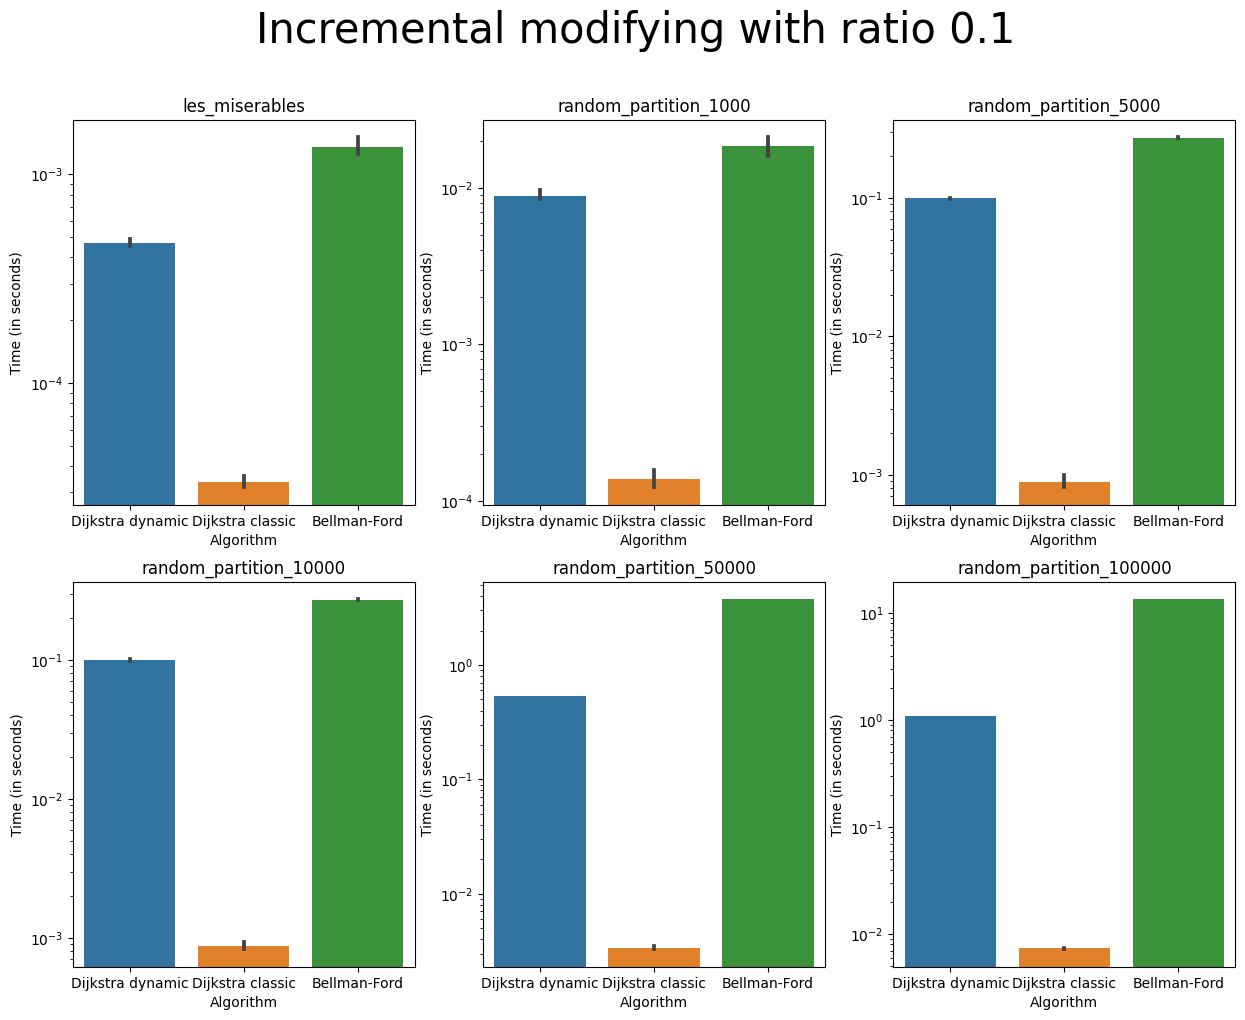

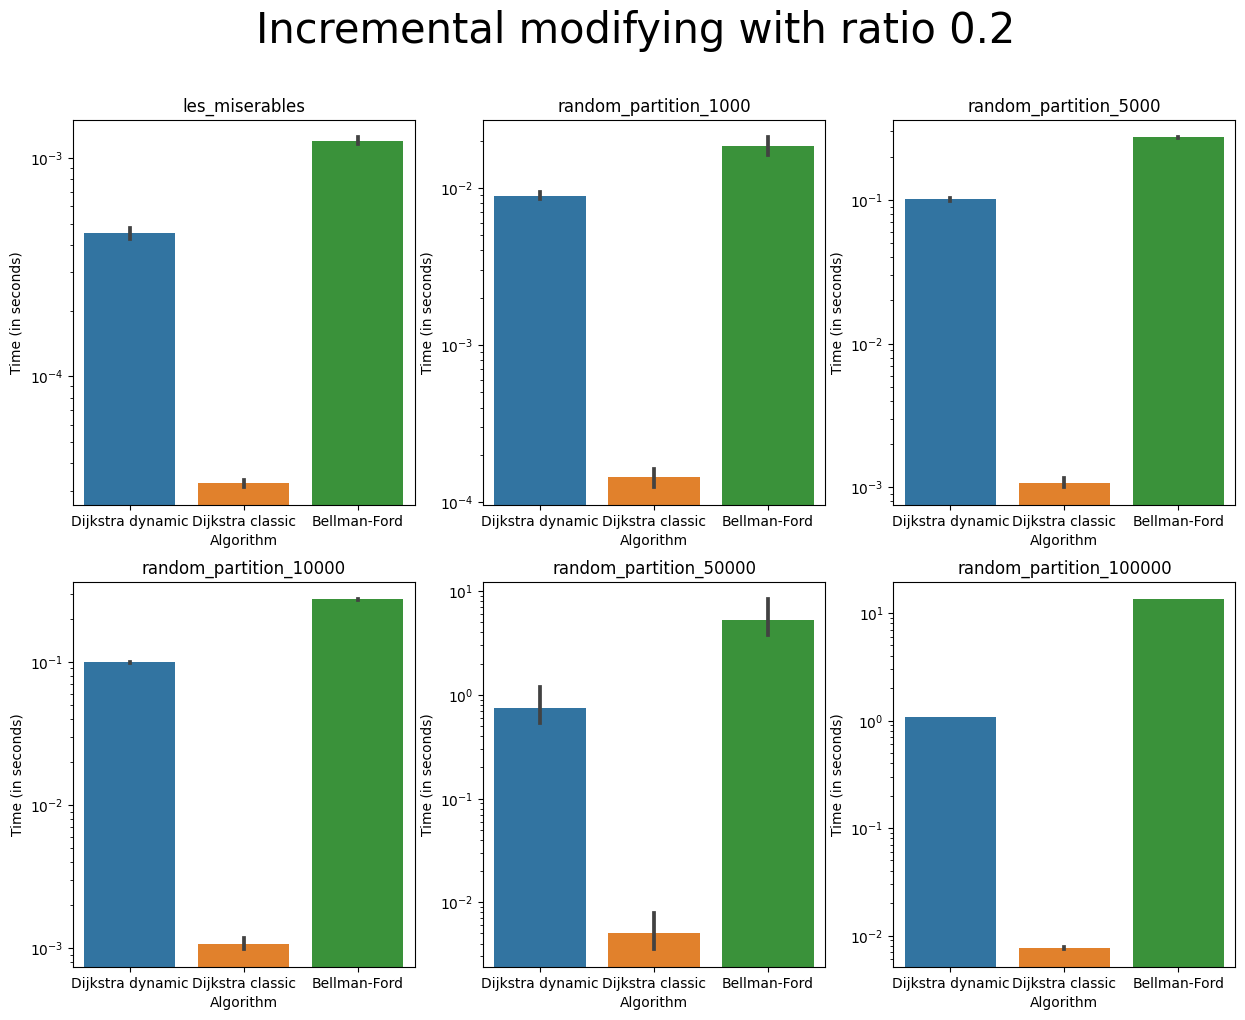

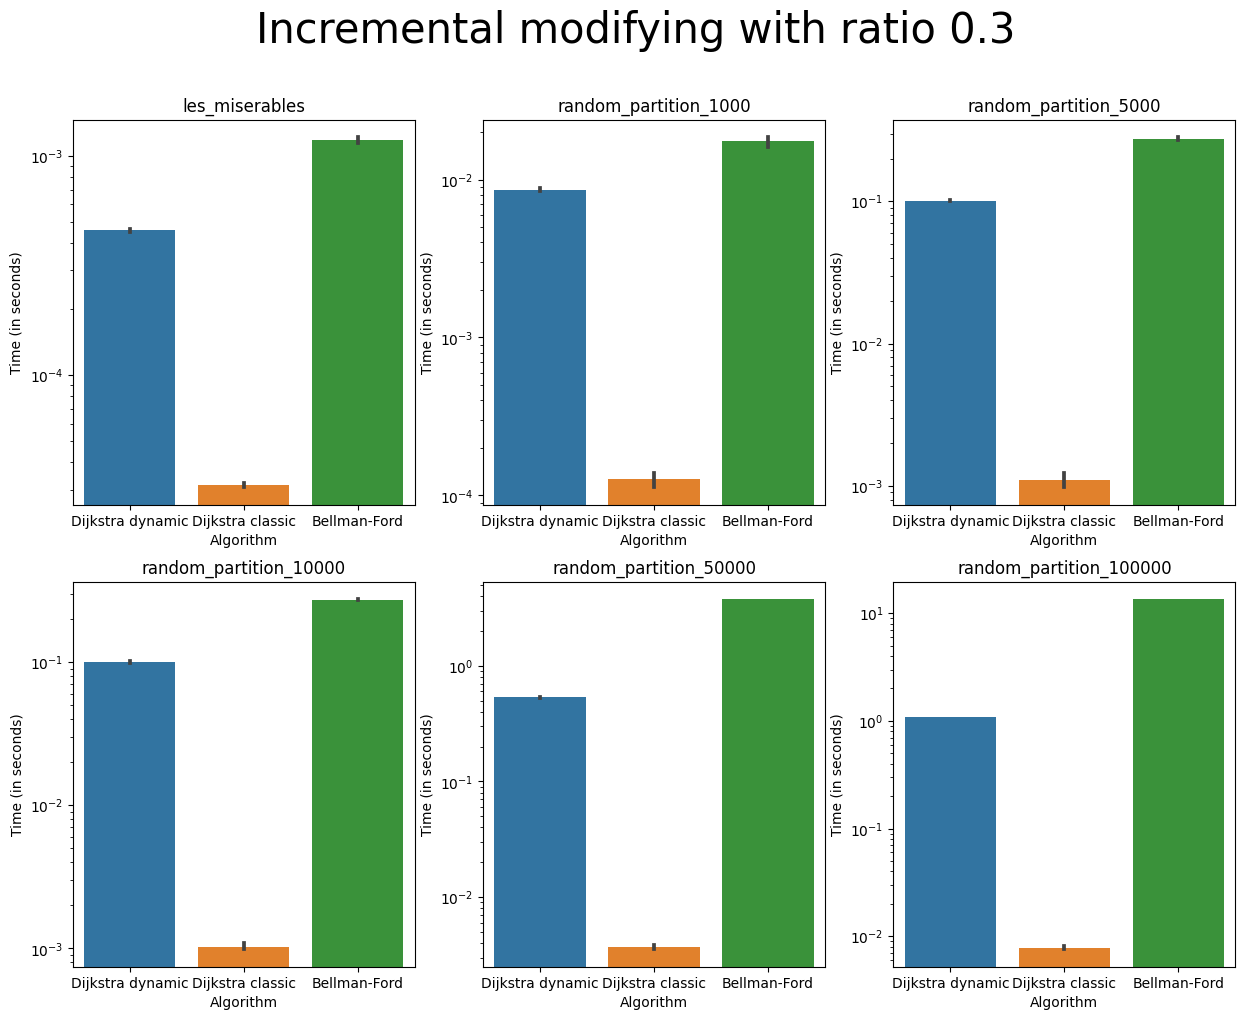

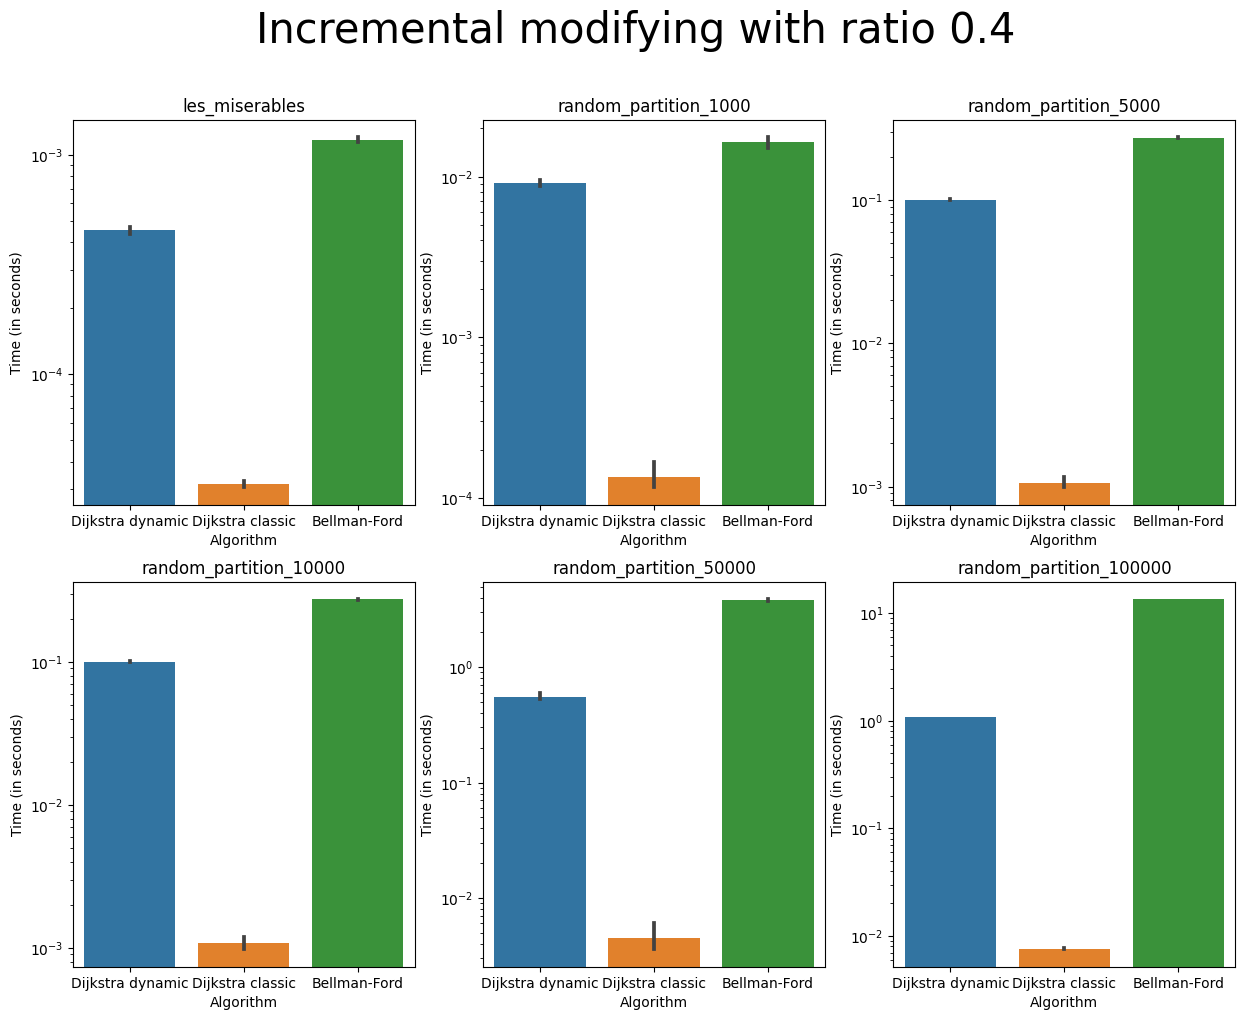

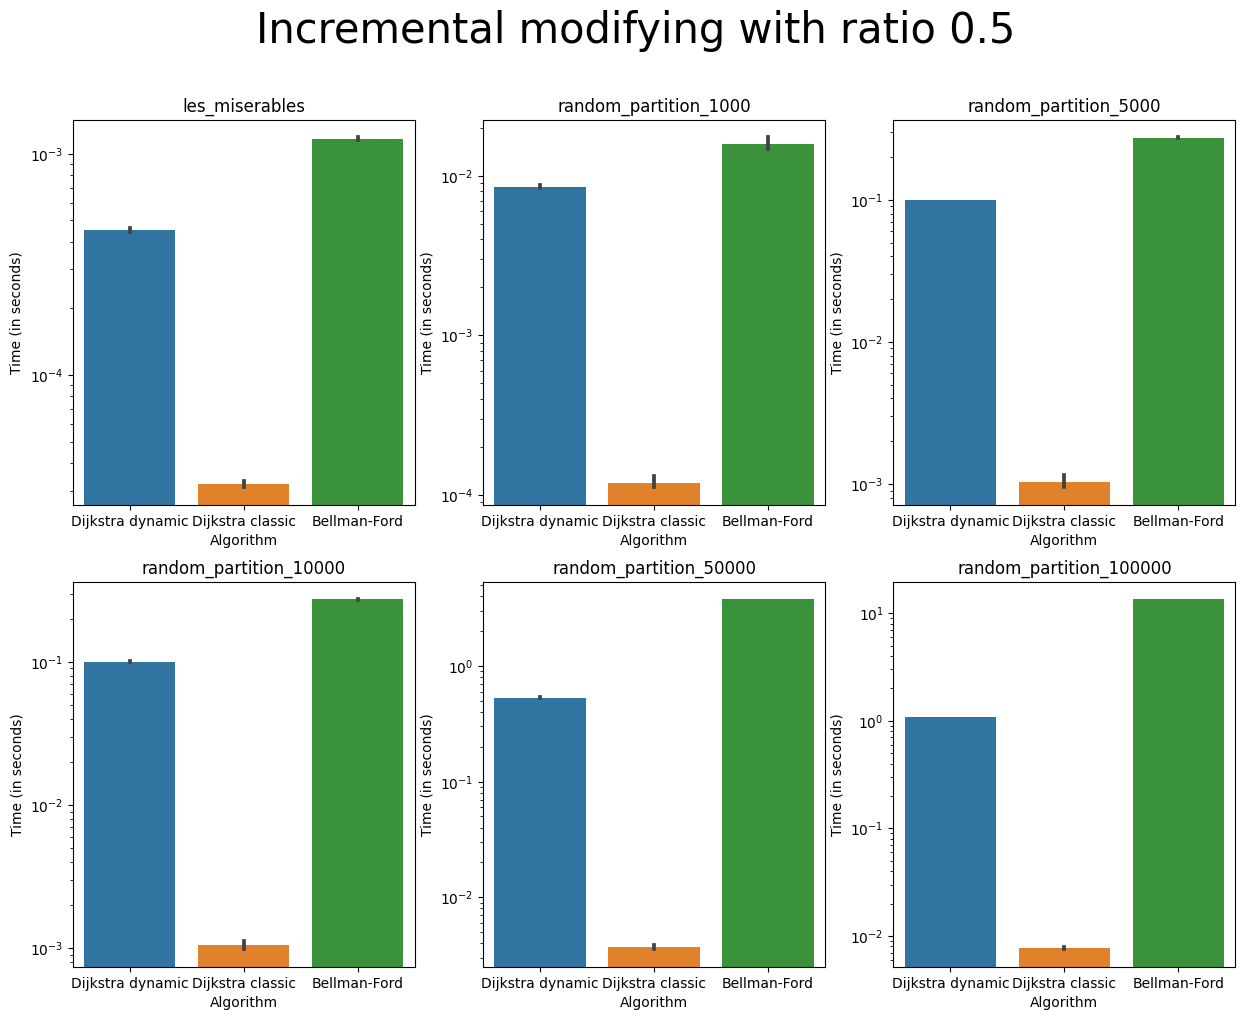

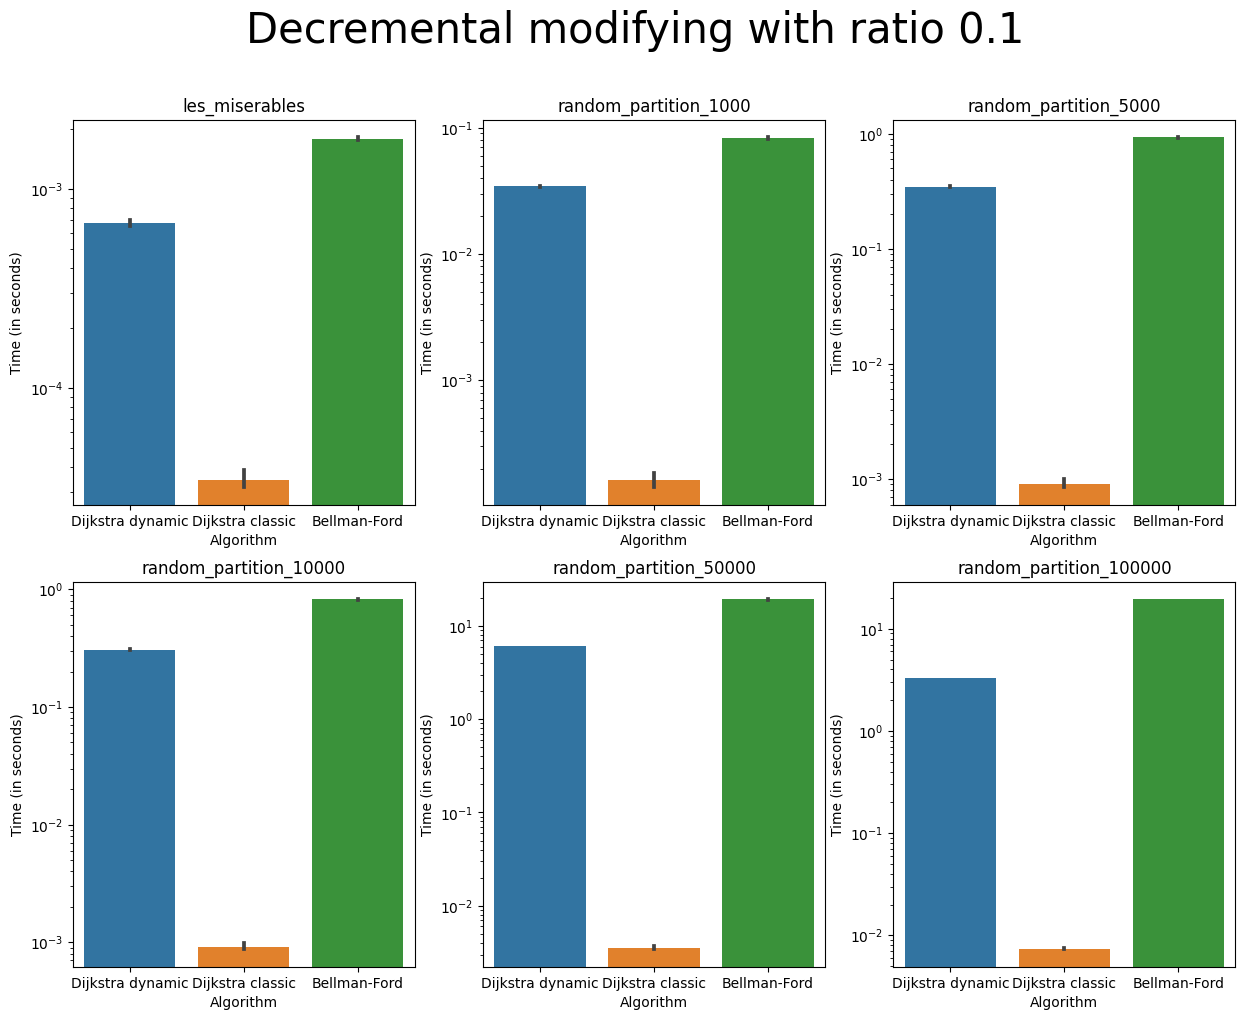

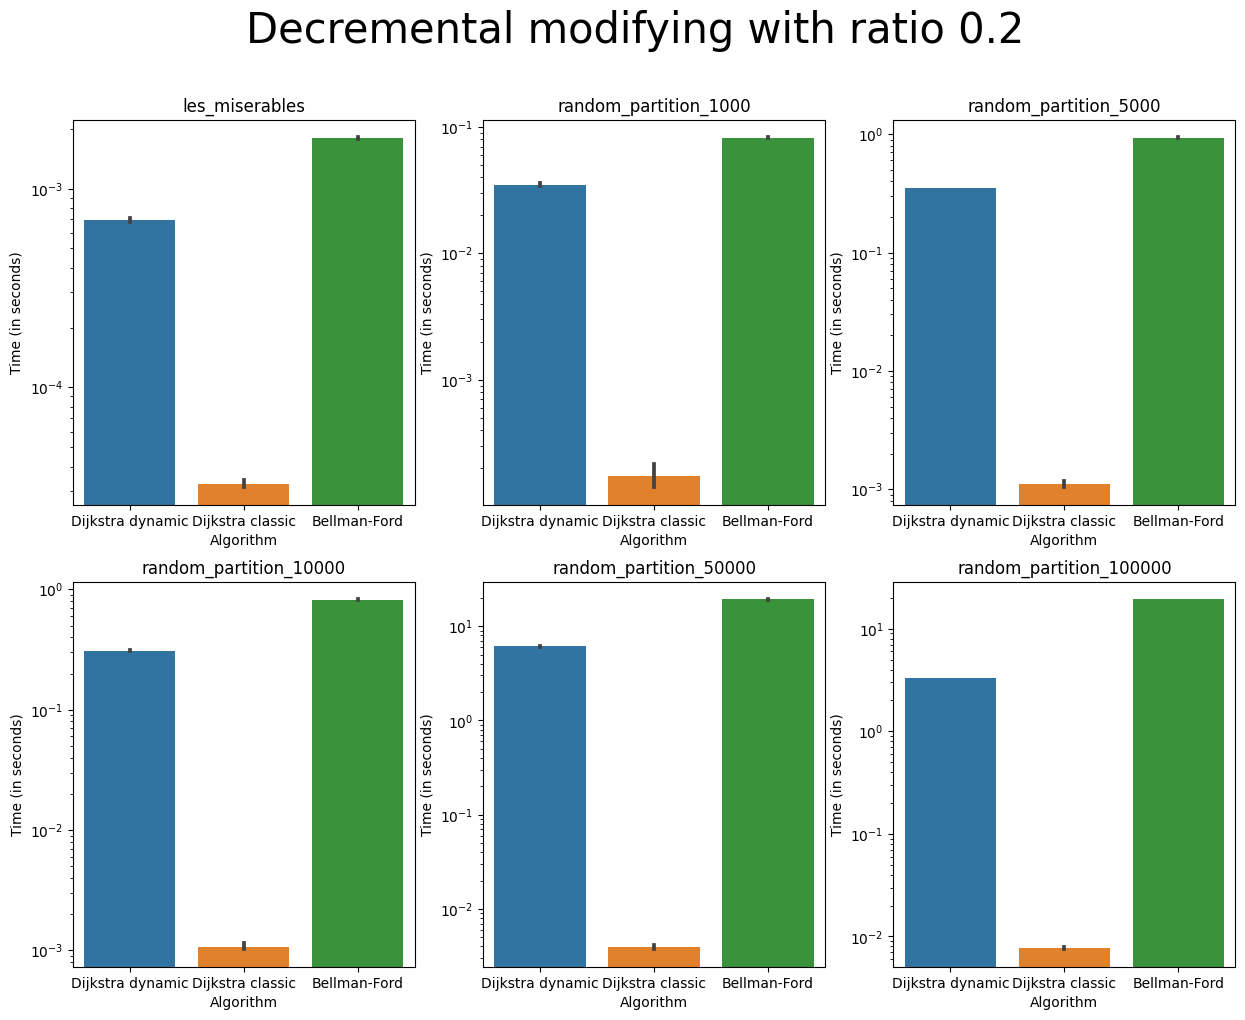

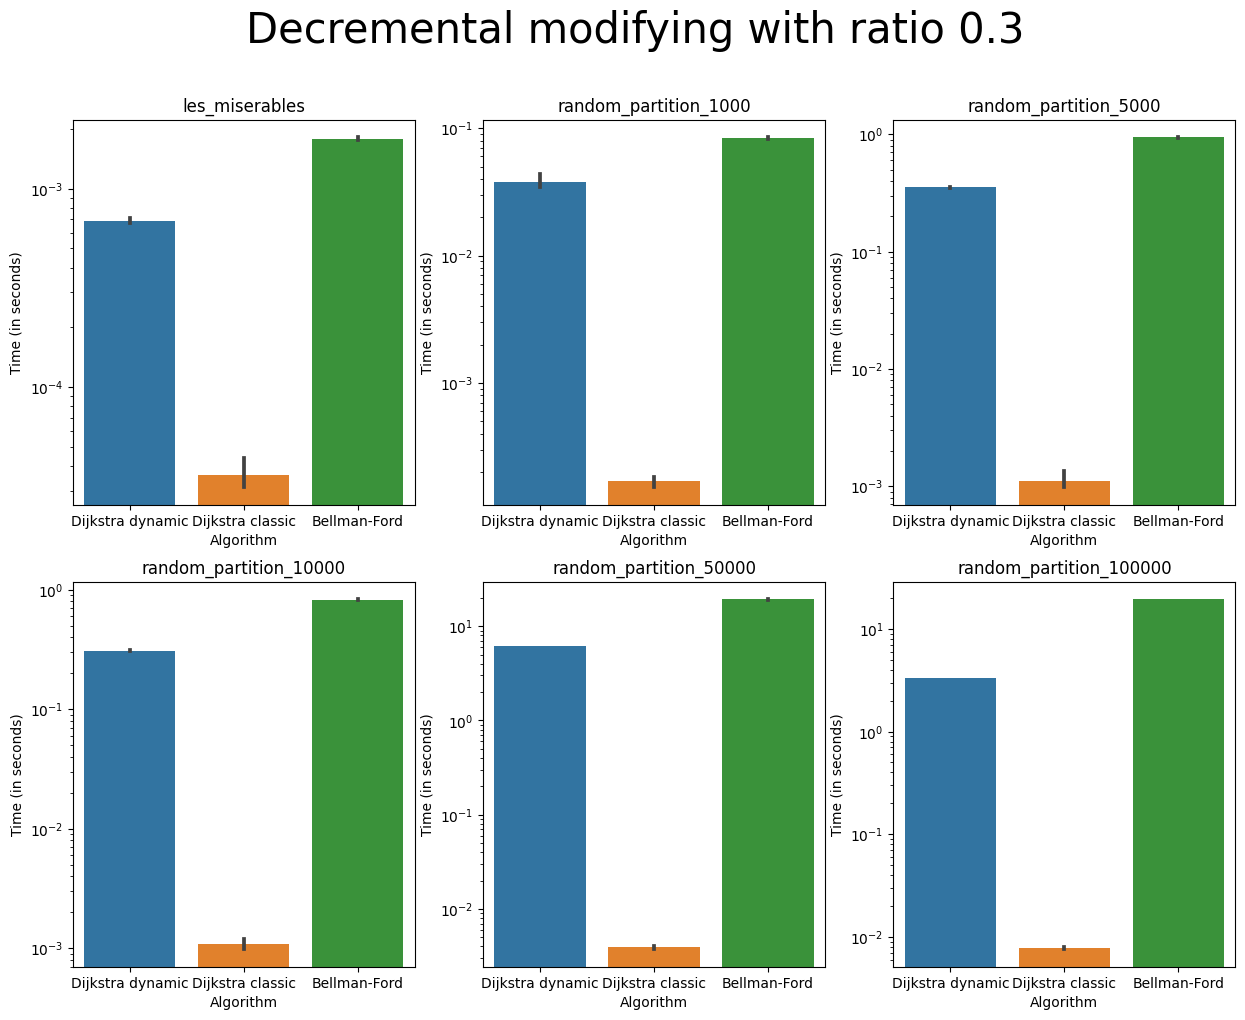

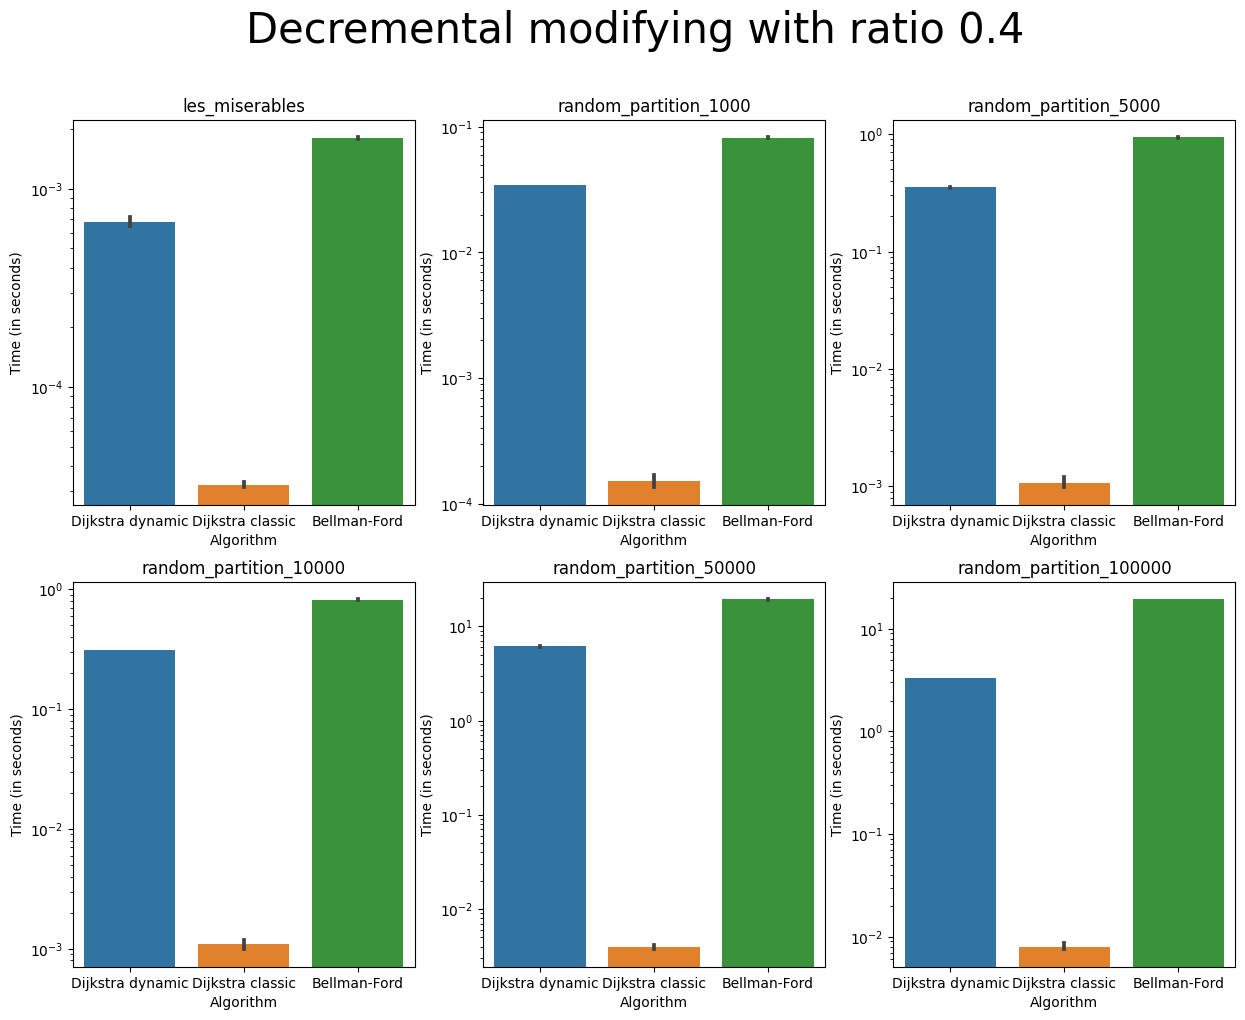

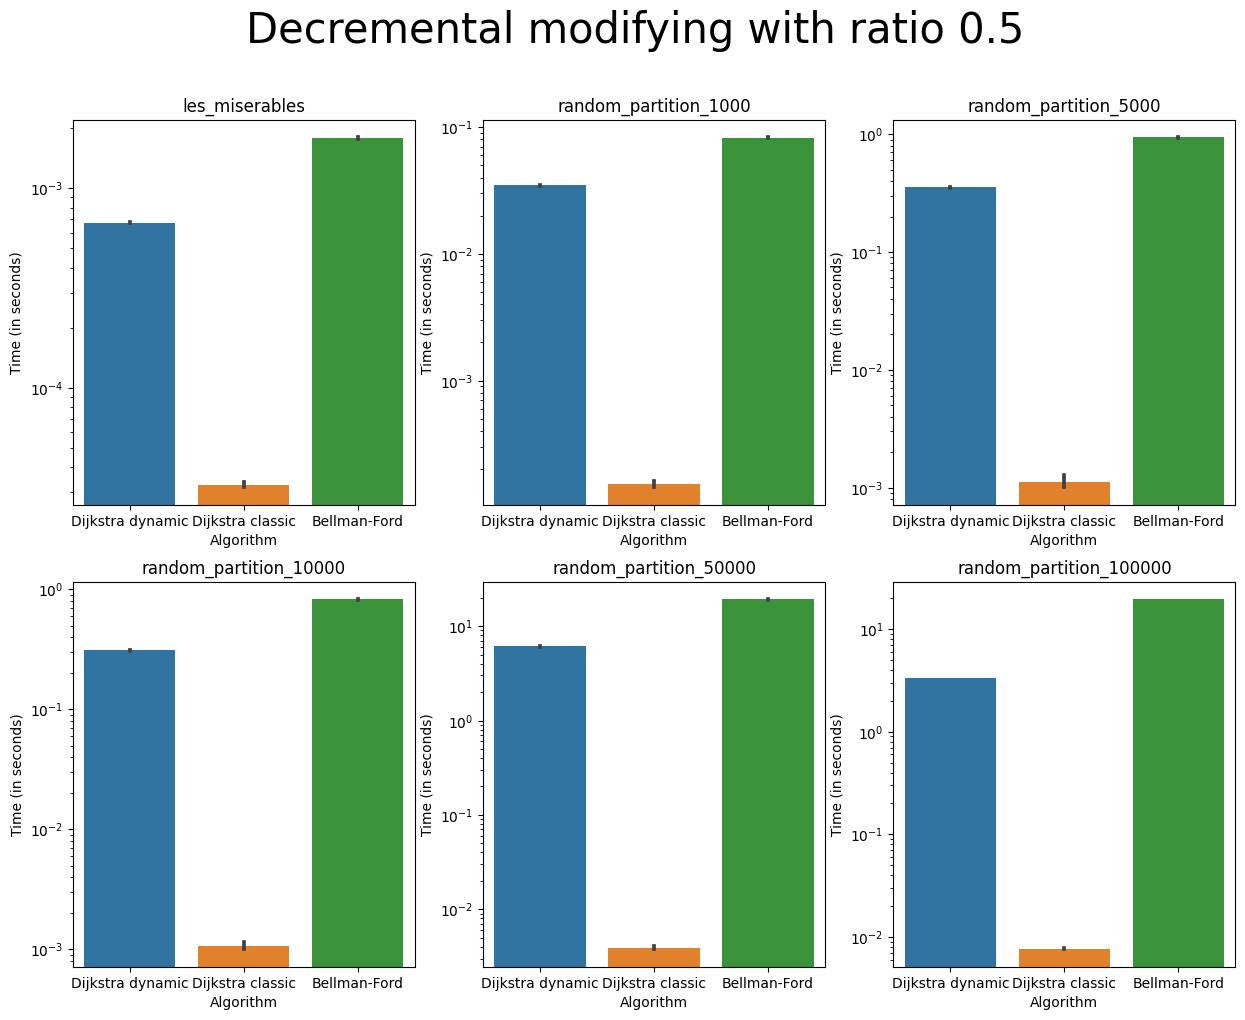

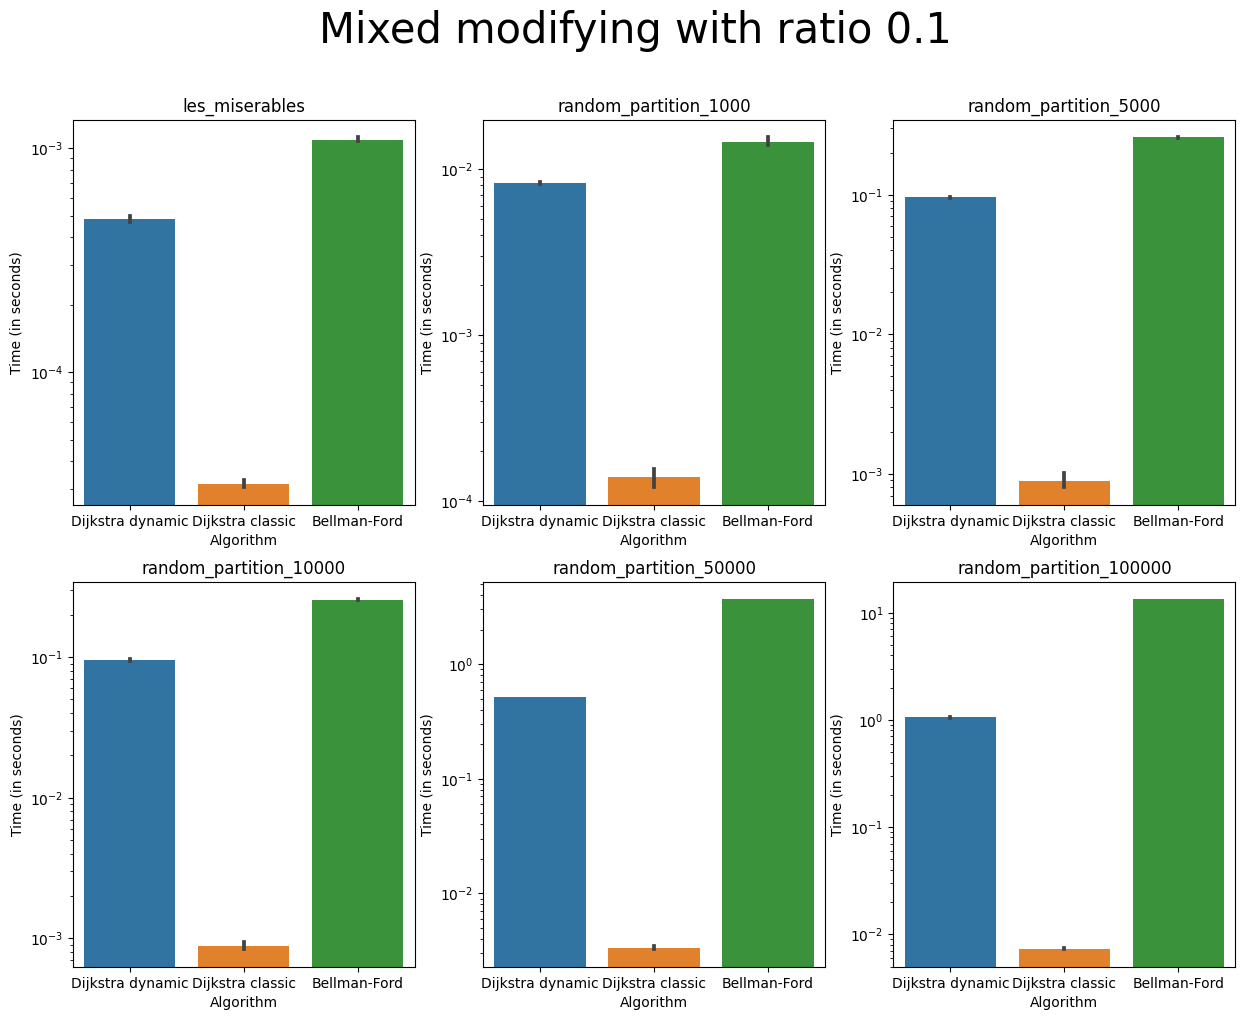

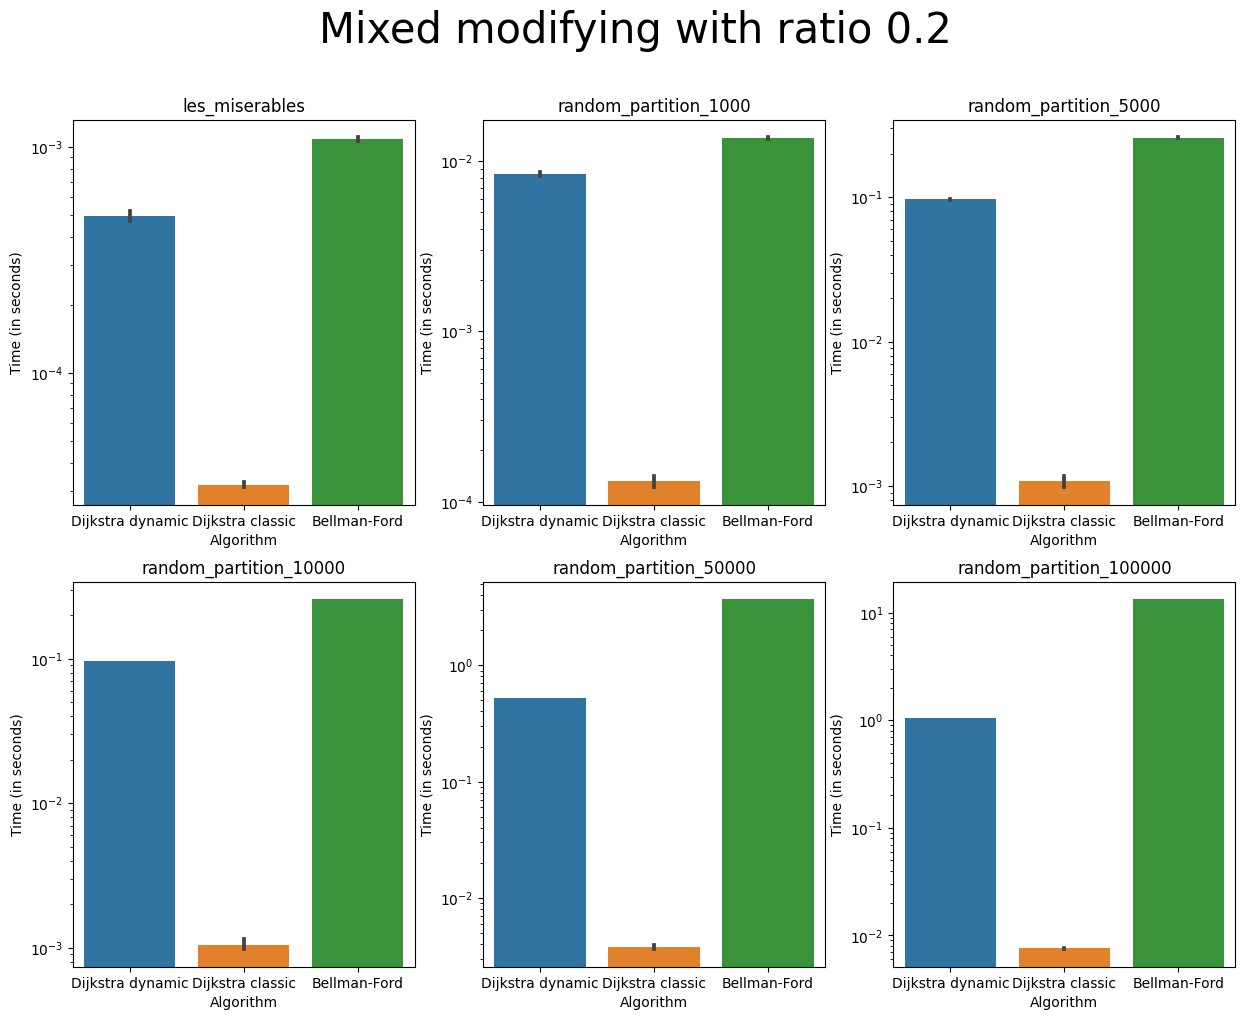

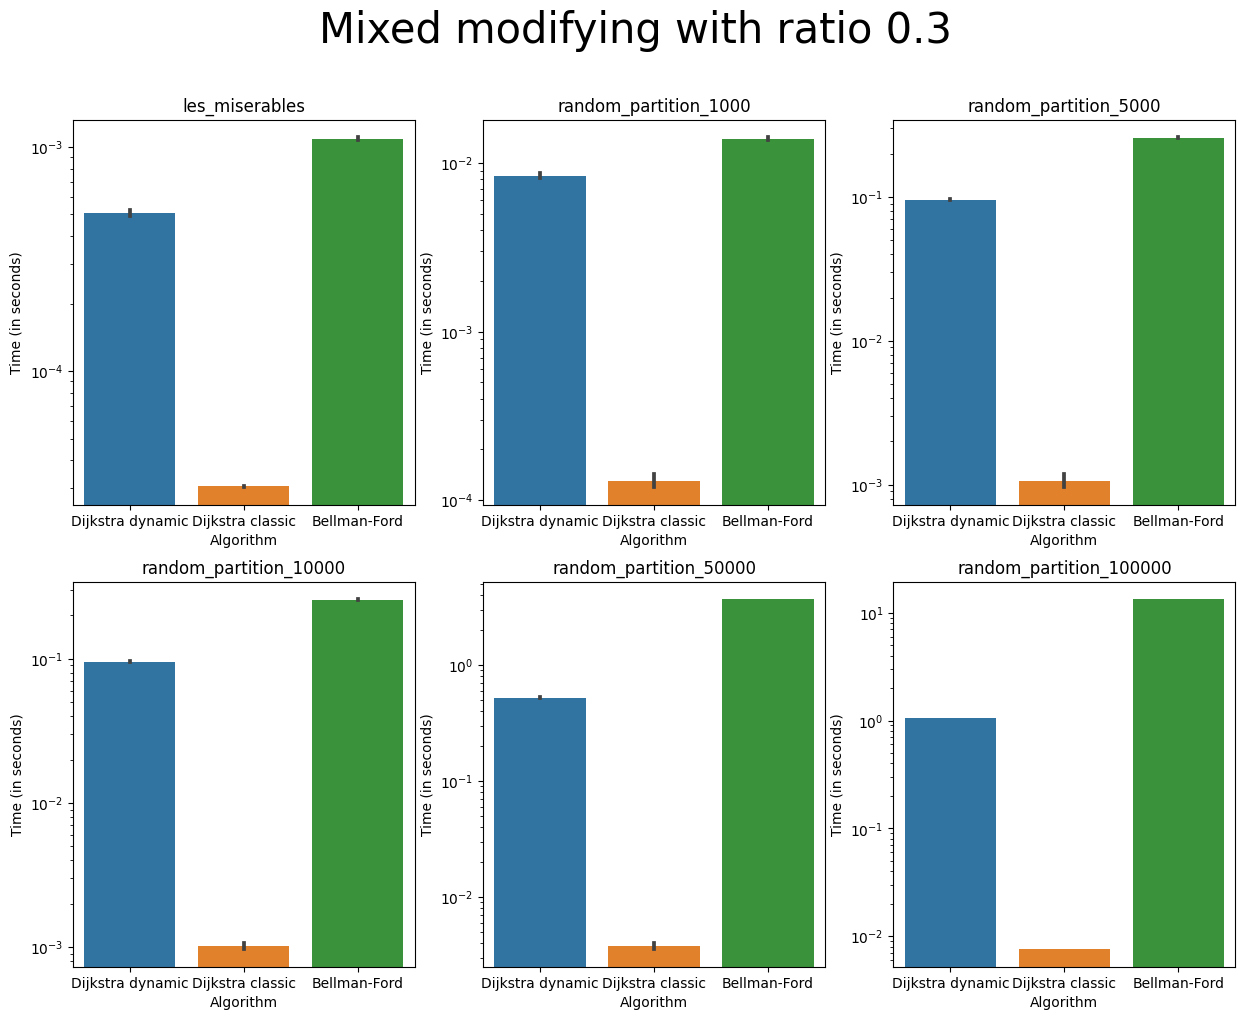

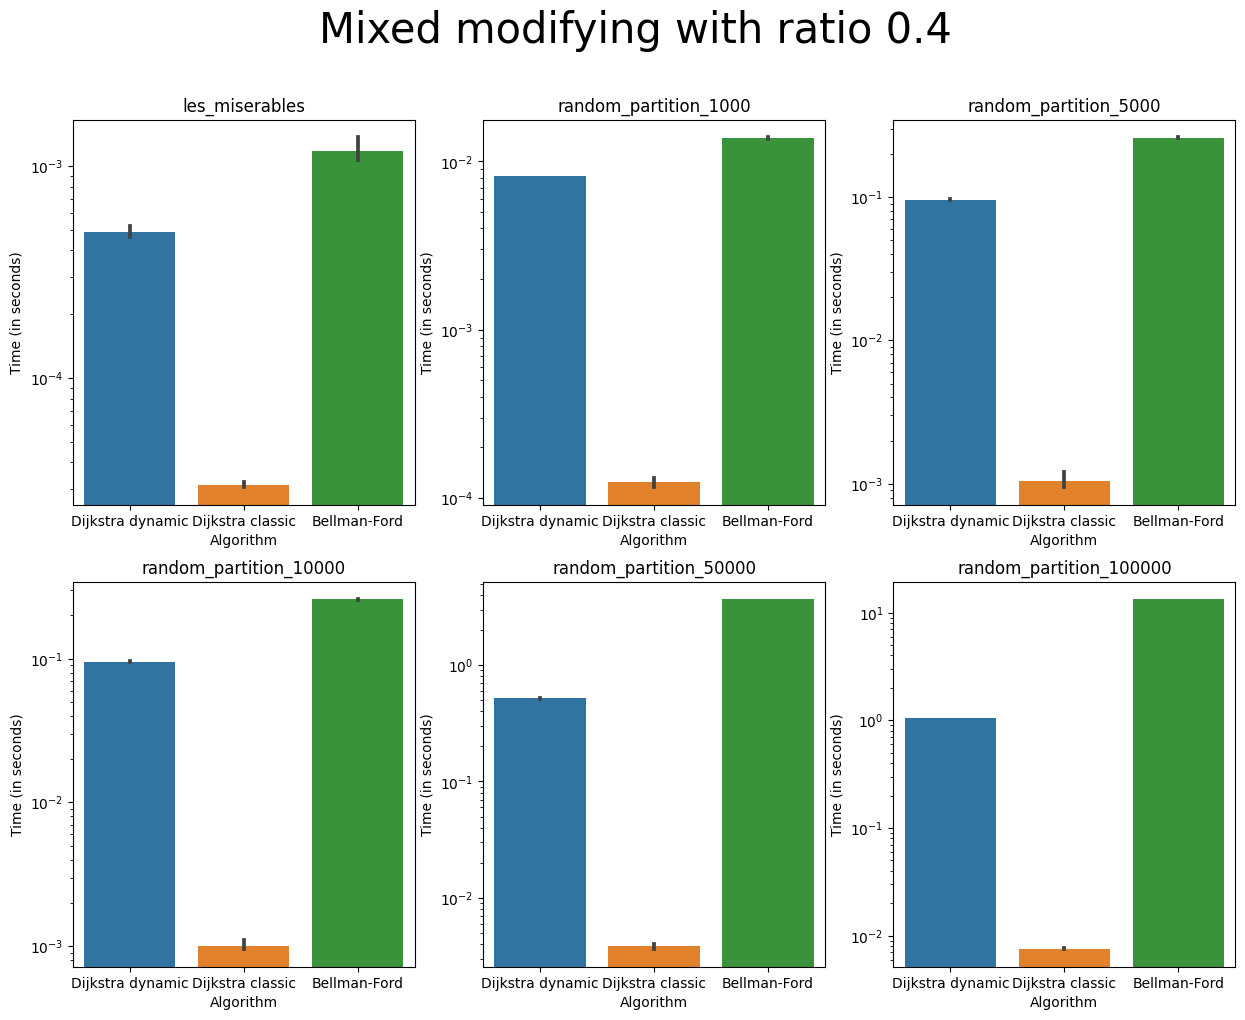

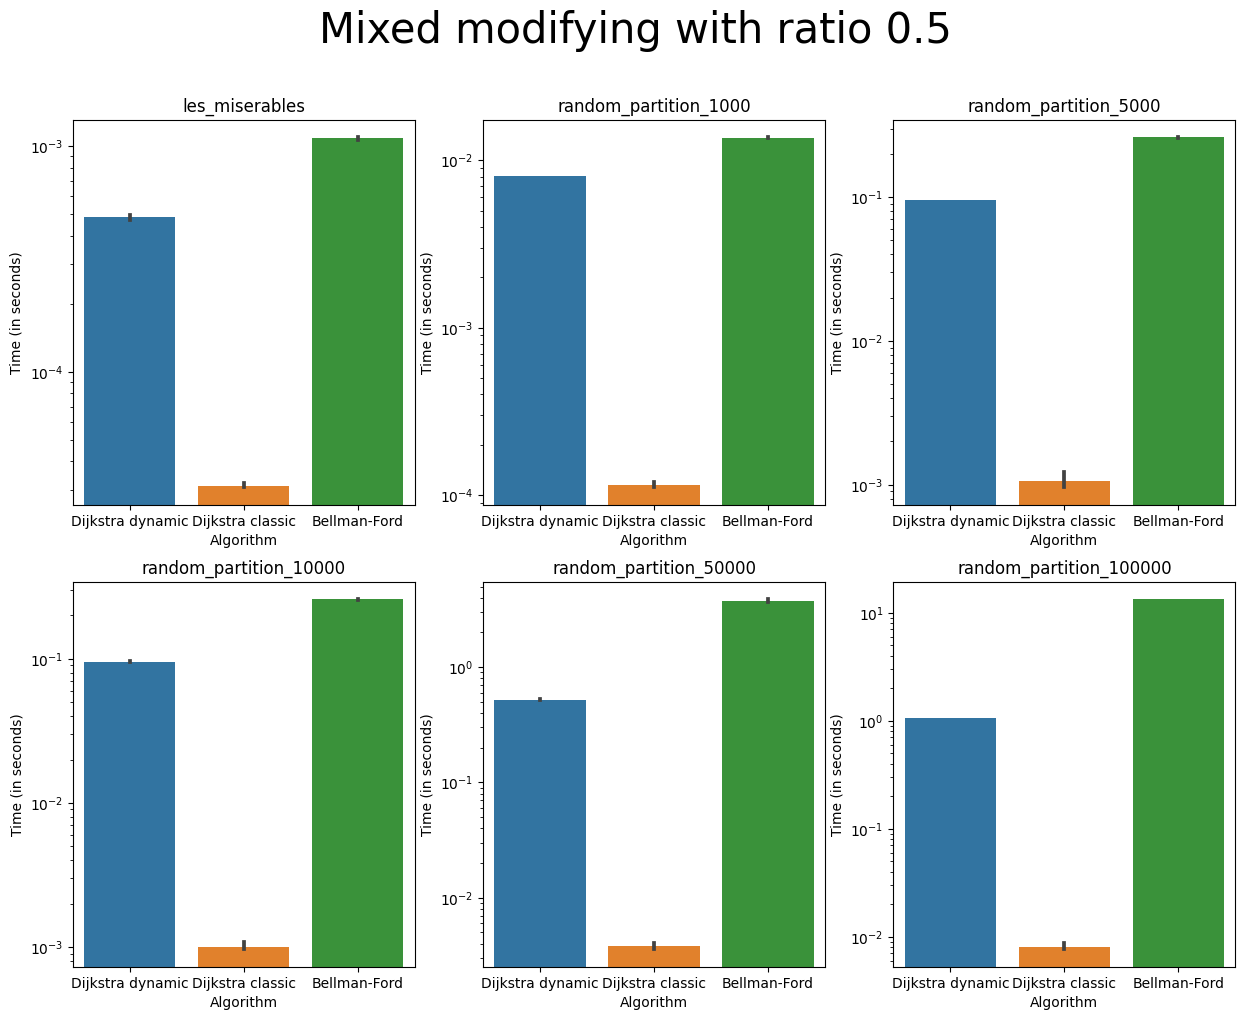

In [40]:
types = ["Incremental", "Decremental", "Mixed"]
for t in types:
    for ratio in edges_ratio:
        make_plot_for(t, ratio)

# Анализ результатов

Как можно видеть, на предложенных данных самым быстрым алгоритмом оказался обычный алгоритм Дейкстры. Судя по тому, насколько быстро он отрабатывал в каждом из сценариев, графы в подборке вряд ли содержать длинные пути, и в целом, скорее всего, не являются связными. 

Медленную работа динамического алгоритма Дейкстры, в данном случае, скорее всего связана с одной из двух причин:
1. Предложенная реализация динамического алгоритма Дейкстры является плохой, и при использовании более оптимальных структур данных и техник написания кода результат мог бы быть лучше.
2. Вершина, от которой происходит поиск расстояний, является сильно изолированной, и обычный алгоритм Дейкстры быстро заканчивает свою работу, в то время как динамический алгоритм долго обновляет расстояния до всех вершин, которые задело обновлением набора ребер.

Также можно заметить, что самый плохой результат на предложенных показал алгоритм Беллмана-Форда. Вероятнее всего это связано с тем, что предложенная реализация данного алгоритма никак не выигрывает от слабой связности графа и делает n матричных умножений (где n - число вершин в графе) в любом случае.